In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, savefig
import matplotlib.colors
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy.matlib
import os
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm 
import fnmatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/tmp/ipykernel_3309/2379291833.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def pot(da,threshold,dim):
    
    assert (threshold>=0) & (threshold<1)
    
    return da.where(da>da.quantile(threshold,dim=dim))

def declustered_peaks(da,threshold,window_len,dim):
    #computes peaks above threshold of xr.DataArray and declusters them with a rolling window.
    
    peaks = pot(da,threshold,dim)
    
    return peaks.where(peaks==peaks.rolling({dim:window_len},center=True,min_periods=1).max(skipna=True))

def rolling_max(da,window_len,dim):
    return da.rolling({dim:window_len},center=True,min_periods=1).max()

In [3]:
max_lag = 0 #days
declus_window_len = 1 #days
threshold = .98 #quantile

output_yrs = np.arange(1880,2100,20)
window_len=40 #may need to increase? indicate settings in output folder?

season = 'year' 
overwrite_output = True

model='MRI-ESM2-0'

get windows

In [4]:
wind = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/timeseries/sfcWind_europe/',model,'MRI-ESM2-0_gn_day_ssp585.nc'))
pr = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/timeseries/pr_europe/',model,'MRI-ESM2-0_gn_day_ssp585.nc'))

sfcWind_pr = xr.merge((wind,pr))
sfcWind_pr_mem = sfcWind_pr.sel(member_id='r1i1p1f1').load()

if len(np.unique(sfcWind_pr.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
    
    sfcWind_pr = sfcWind_pr.sel(time=~((sfcWind_pr.time.dt.month == 2) & (sfcWind_pr.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results

#select DJF:
days_in_year = int(sfcWind_pr.time.resample(time='1Y').count()[0])

if window_len%2 !=0: #odd
    window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
    first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
else: #even
    window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
    first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)

if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(sfcWind_pr.time):
    raise Exception('Windows exceed simulation length.')

window_idx = xr.DataArray( #indices of windows
    data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
    dims=["time_in_window_idx","window"],
    coords=dict(
        time_in_window_idx=first_window_idx,
        window=output_yrs
    ),
)

sfcWind_pr_wdws = sfcWind_pr.isel(time=window_idx) #select windows        

In [5]:
pr_hist_threshold = sfcWind_pr_wdws['pr'].sel(window=1980).quantile(threshold,dim='time_in_window_idx')
sfcWind_hist_threshold = sfcWind_pr_wdws['sfcWind'].sel(window=1980).quantile(threshold,dim='time_in_window_idx')

pr_peaks = sfcWind_pr_wdws['pr'].where(sfcWind_pr_wdws['pr']>pr_hist_threshold)
sfcWind_peaks = sfcWind_pr_wdws['sfcWind'].where(sfcWind_pr_wdws['sfcWind']>sfcWind_hist_threshold)

pr_peaks_declustered = pr_peaks.where(pr_peaks==pr_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
sfcWind_peaks_declustered = sfcWind_peaks.where(sfcWind_peaks==sfcWind_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))

In [6]:
eqv_pct = (1-np.isfinite(pr_peaks_declustered).sum(dim='time_in_window_idx')/len(pr_peaks_declustered.time_in_window_idx))

In [7]:
np.isfinite(pr_peaks_declustered).sum(dim='time_in_window_idx').isel(member_id=0).sel(window=2080)

<xarray.DataArray 'pr' (latitude: 34, longitude: 51)>
array([[334, 312, 290, ..., 215, 216, 226],
       [385, 357, 321, ..., 216, 254, 250],
       [372, 367, 366, ..., 260, 277, 285],
       ...,
       [287, 264, 274, ..., 542, 555, 558],
       [336, 360, 357, ..., 520, 547, 578],
       [363, 372, 383, ..., 521, 569, 602]])
Coordinates:
    member_id  <U8 'r1i1p1f1'
    height     float64 10.0
  * longitude  (longitude) int64 -30 -29 -28 -27 -26 -25 ... 15 16 17 18 19 20
  * latitude   (latitude) int64 35 36 37 38 39 40 41 42 ... 62 63 64 65 66 67 68
    window     int64 2080
    quantile   float64 0.98

Use the # of exceedances in the future period to select the peaks in the historical period that would have exceeded that percentile in the historical period

Think about how this would work with lag & declustering?

pr_eqv_thresholds = sfcWind_pr_wdws.sel(window=1980).pr.sortby('time_in_window_idx',ascending=False).isel(time_in_window_idx=np.isfinite(pr_peaks_declustered).sum(dim='time_in_window_idx').sel(window=2080))
wind_eqv_thresholds = sfcWind_pr_wdws.sel(window=1980).sfcWind.sortby('time_in_window_idx',ascending=False).isel(time_in_window_idx=np.isfinite(sfcWind_peaks_declustered).sum(dim='time_in_window_idx').sel(window=2080))

In [8]:
sorted_pr_1980 = xr.DataArray(data=np.sort(sfcWind_pr_wdws.sel(window=1980).pr,axis=1),dims=['member_id','time_in_window_idx','latitude','longitude'],coords=dict(member_id=sfcWind_pr_wdws.member_id,time_in_window_idx=sfcWind_pr_wdws.time_in_window_idx,latitude=sfcWind_pr_wdws.latitude,longitude=sfcWind_pr_wdws.longitude))
sorted_sfcWind_1980 = xr.DataArray(data=np.sort(sfcWind_pr_wdws.sel(window=1980).sfcWind,axis=1),dims=['member_id','time_in_window_idx','latitude','longitude'],coords=dict(member_id=sfcWind_pr_wdws.member_id,time_in_window_idx=sfcWind_pr_wdws.time_in_window_idx,latitude=sfcWind_pr_wdws.latitude,longitude=sfcWind_pr_wdws.longitude))

In [9]:
pr_eqv_thresholds = sorted_pr_1980.isel(time_in_window_idx=-1*(np.isfinite(pr_peaks_declustered).sum(dim='time_in_window_idx').sel(window=2080)))
wind_eqv_thresholds = sorted_sfcWind_1980.isel(time_in_window_idx=-1*(np.isfinite(sfcWind_peaks_declustered).sum(dim='time_in_window_idx').sel(window=2080)))

In [10]:
pr_peaks_fut_threshold = sfcWind_pr_wdws.pr.sel(window=1980).where(sfcWind_pr_wdws.pr.sel(window=1980)>=pr_eqv_thresholds)
sfcWind_peaks_fut_threshold = sfcWind_pr_wdws.sfcWind.sel(window=1980).where(sfcWind_pr_wdws.sfcWind.sel(window=1980)>=wind_eqv_thresholds)

In [11]:
num_co_occurring = np.isfinite((rolling_max(pr_peaks_declustered,max_lag*2+1,dim='time_in_window_idx')*sfcWind_peaks_declustered)).sum(dim='time_in_window_idx')

#historical with future thresholds percentiles applied to historical period:

#co occurring pr fut threshold
num_co_occurring_pr_eqv = np.isfinite((rolling_max(pr_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*sfcWind_peaks_declustered.sel(window=1980))).sum(dim='time_in_window_idx')

#co occurring wind fut threshold 
num_co_occurring_wind_eqv = np.isfinite((rolling_max(pr_peaks_declustered.sel(window=1980),max_lag*2+1,dim='time_in_window_idx')*sfcWind_peaks_fut_threshold)).sum(dim='time_in_window_idx')

#co occurring both new threshold
num_co_occurring_both_eqv = np.isfinite((rolling_max(pr_peaks_fut_threshold,max_lag*2+1,dim='time_in_window_idx')*sfcWind_peaks_fut_threshold)).sum(dim='time_in_window_idx')



In [12]:
mri_dependence = xr.open_dataset('/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc')

Text(0.5, 1.0, 'd98-d97 future')

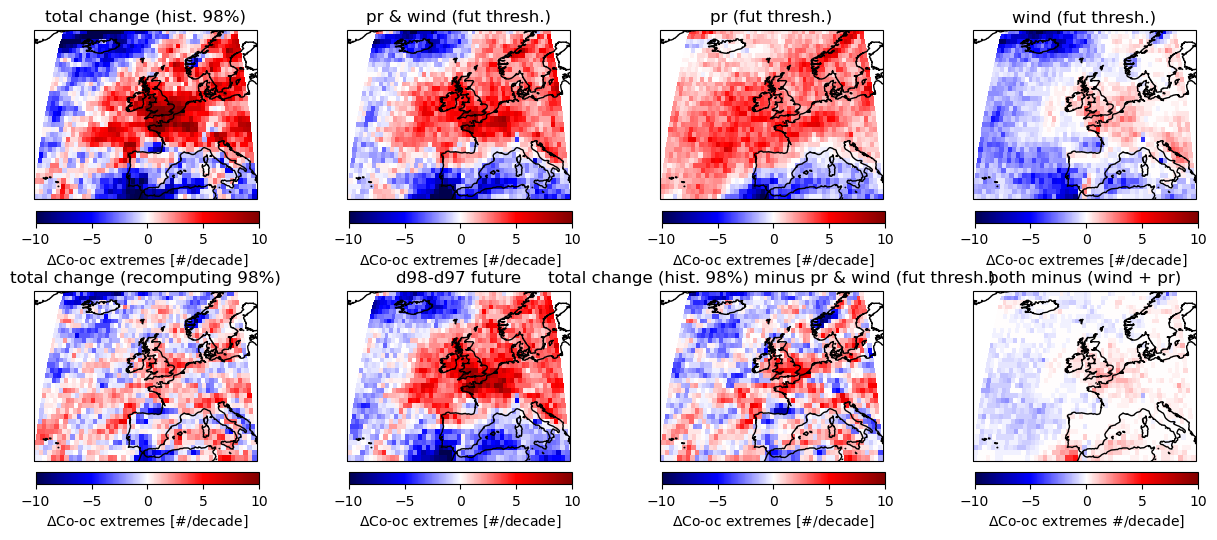

In [18]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-num_co_occurring.mean(dim='member_id').sel(window=1980))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring_both_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & wind (fut thresh.)')
        
ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring_pr_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')
        
        
ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring_wind_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('wind (fut thresh.)')    


#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')
ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring_both_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980)-(num_co_occurring_wind_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980))-(num_co_occurring_pr_eqv.mean(dim='member_id')-num_co_occurring.mean(dim='member_id').sel(window=1980)))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (wind + pr)')   


ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-num_co_occurring_both_eqv.mean(dim='member_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%) minus pr & wind (fut thresh.)')   


ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   

